In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np

In [2]:
row_train_data = pd.read_csv('./dataset/train.csv')
row_train_data.drop(columns='Location', inplace=True)
for idx, row in row_train_data.iterrows():
    row_train_data.loc[idx] = [s.replace(' ', '') for s in row.values]
row_train_data['Month'] = row_train_data['Date'].apply(lambda x: x[:x.find('/')])

item_list = list(row_train_data.groupby('ItemName').groups.keys())
item_train_data = {}
for item in item_list:
    item_row_data = row_train_data[row_train_data['ItemName'] == item]
    train_list = []
    for _, row in item_row_data.iterrows():
        row = row.values[2:]
        for i in range(len(row)):
            try:
                row[i] = float(row[i])
            except:
                row[i] = None
        train_list.extend(row[:-1])
    train_list = np.array(train_list).reshape(12, 480)
    item_train_data[item] = train_list


random_seed = 10
num_sample = 500
np.random.seed(random_seed)
sample_idx = np.random.randint(0, 470, (12, num_sample))


train_data = []
label = []
dropna = True
data_index = 0
for month in range(12):
    for i in sample_idx[month]:
        single_data = []
        for item in item_list:
            row = [data_index, month+1, item]
            row.extend(item_train_data[item][month][i:i+10])
            if dropna and None in row:
                single_data.clear()
                break
            else:
                single_data.append(row)
        if single_data:
            train_data.extend(single_data)
            label.extend([single_data[9][-1]] * 18)
            data_index += 1


header = ['DataIndex', 'Month', 'Item']
header.extend([f'{i}' for i in range(10)])


print(header)
train_data = pd.DataFrame(train_data, columns=header)
train_data['Label'] = label
train_data.drop(columns=['9', 'Month'], inplace=True)
train_data

['DataIndex', 'Month', 'Item', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


,DataIndex,Item,0,1,2,3,4,5,6,7,8,Label
0,0,AMB_TEMP,16.30,15.60,14.80,14.40,14.50,14.70,14.70,14.60,14.40,10.0
1,0,CH4,1.97,1.97,2.00,2.02,2.01,2.01,2.00,1.98,1.98,10.0
2,0,CO,0.29,0.29,0.33,0.34,0.34,0.34,0.29,0.24,0.21,10.0
3,0,NMHC,0.07,0.08,0.12,0.13,0.10,0.10,0.09,0.05,0.06,10.0
4,0,NO,2.60,2.30,2.00,1.80,1.80,1.80,1.70,1.50,1.40,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...
83623,4645,THC,2.13,2.09,2.07,2.10,2.12,2.14,2.15,2.19,2.19,33.0
83624,4645,WD_HR,38.00,40.00,39.00,47.00,45.00,41.00,43.00,42.00,41.00,33.0
83625,4645,WIND_DIREC,46.00,38.00,44.00,50.00,46.00,42.00,45.00,46.00,35.00,33.0
83626,4645,WIND_SPEED,3.30,4.00,2.70,4.60,4.60,5.10,4.90,6.00,5.40,33.0


In [3]:
test_data = pd.read_csv('./dataset/test.csv', header=None)
test_data.columns = train_data.columns[:-1]
for idx, row in test_data.iterrows():
    test_data.loc[idx] = [s.replace(' ', '') for s in row.values]
test_data['DataIndex'] = test_data['DataIndex'].apply(lambda x: int(x.replace('index_', '')))
test_data


,DataIndex,Item,0,1,2,3,4,5,6,7,8
0,0,AMB_TEMP,18.2,17.8,17.5,17.5,17.7,18.1,18.2,18.7,20.3
1,0,CH4,2.41,2.61,2.65,2.87,2.25,2.24,2.45,2.59,2.24
2,0,CO,0.77,0.74,0.63,0.6,0.36,0.31,0.48,1.01,1.05
3,0,NMHC,0.29,0.34,0.34,0.37,0.18,0.15,0.24,0.43,0.35
4,0,NO,6.8,11.1,9.6,13.6,3.1,2.4,17.8,49.5,41.1
...,...,...,...,...,...,...,...,...,...,...,...
4387,243,THC,2.07,2.05,2.09,2.1,2.05,2.1,2.15,2.13,2.09
4388,243,WD_HR,51,54,48,53,54,53,47,37,42
4389,243,WIND_DIREC,66,45,40,59,57,55,41,36,53
4390,243,WIND_SPEED,4.8,3.2,2.8,3.2,2.5,2.2,1.7,2.5,2.3


In [5]:
class LinearRegression:
    def __init__(self):
        self.closed_form_weights = None
        self.closed_form_intercept = None
        self.gradient_descent_weights = None
        self.gradient_descent_intercept = None
        self.loss = []
        
    # This function computes the closed-form solution of linear regression.
    def closed_form_fit(self, X, y):
        # Compute closed-form solution.
        # Save the weights and intercept to self.closed_form_weights and self.closed_form_intercept

        # Sample data for linear regression

        # Add a bias term (intercept) to the input features
        X = np.c_[np.ones((X.shape[0], 1)), X]
        X_T = X.T
        # Compute the closed-form solution
        theta = np.linalg.inv(X_T.dot(X)).dot(X_T).dot(y)
        self.closed_form_intercept, self.closed_form_weights = theta[0], theta[1:]
        pass

    # This function computes the gradient descent solution of linear regression.
    def gradient_descent_fit(self, X, y, lr, epochs):
        # Compute the solution by gradient descent.
        # Save the weights and intercept to self.gradient_descent_weights and self.gradient_descent_intercept
        
        initial_theta = np.random.rand(X.shape[1] + 1)  # Initialize theta randomly
        # Add a bias term (intercept) to the input features
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        # Gradient Descent
        theta = initial_theta.copy()
        gradient = np.zeros(X_b.shape[1])
        self.loss.clear()
        for iteration in range(epochs):
            y_pred = X_b.dot(theta)
            error = y_pred - y
            mse = (1 / X.shape[0]) * np.sum(np.square(error))
            self.loss.append(mse)
            
            gradient = (2 / X.shape[0]) * X_b.T.dot(error)
            theta -= lr * gradient

        # The final values of theta represent the coefficients of the linear regression model
        self.gradient_descent_intercept, self.gradient_descent_weights = theta[0], theta[1:]


        pass
        

    # This function compute the MSE loss value between your prediction and ground truth.
    def get_rmse_loss(self, prediction, ground_truth):
        # Return the value.
        return np.sqrt(sum(np.square(prediction - ground_truth)) / prediction.shape[0])
        pass

    # This function takes the input data X and predicts the y values according to your closed-form solution.
    def closed_form_predict(self, X):
        # Return the prediction.
        return X.dot(self.closed_form_weights) + self.closed_form_intercept
        pass

    # This function takes the input data X and predicts the y values according to your gradient descent solution.
    def gradient_descent_predict(self, X):
        # Return the prediction.
        return X.dot(self.gradient_descent_weights) + self.gradient_descent_intercept
        pass
    
    # This function takes the input data X and predicts the y values according to your closed-form solution, 
    # and return the MSE loss between the prediction and the input y values.
    def closed_form_evaluate(self, X, y):
        # This function is finished for you.
        return self.get_rmse_loss(self.closed_form_predict(X), y)

    # This function takes the input data X and predicts the y values according to your gradient descent solution, 
    # and return the MSE loss between the prediction and the input y values.
    def gradient_descent_evaluate(self, X, y):
        # This function is finished for you.
        return self.get_rmse_loss(self.gradient_descent_predict(X), y)
        
    # This function use matplotlib to plot and show the learning curve (x-axis: epoch, y-axis: training loss) of your gradient descent solution.
    # You don't need to call this function in your submission, but you have to provide the screenshot of the plot in the report.
    def plot_learning_curve(self):
        plt.figure(figsize=(15, 10))
        plt.plot(self.loss, marker = 'o', linestyle = '-')
        plt.title('Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('MSE Loss')
        plt.show()
        pass
def feature_corr(item, option: str):
    option_list = ['last', 'mean']
    if option not in option_list:
        raise('Option error')
    feature_data = train_data[train_data['Item'] == item]
    feature_avg = []
    for _, row in feature_data.iterrows():
        avg = None
        if option == 'last':
            avg = row.values[2:-1][-1]
        elif option == 'mean':
            avg = row.values[2:-1][-4:-1].mean()
        feature_avg.append(avg)
    plot_handle = np.array([feature_avg, list(feature_data['Label'])])
    plt.scatter(plot_handle[0], plot_handle[1])
    plt.xlabel(f'{item} Avg.')
    plt.ylabel('Label')
    plt.show()

def feature_extract(data, train_flag=True):
    global feature_list, feature_num
    X = np.zeros((data['DataIndex'][len(data)-1] + 1, feature_num + 1 if train_flag else feature_num))
    features = []
    current_idx = 0
    for i, row in data.iterrows():
        if row['DataIndex'] == current_idx + 1:
            if train_flag: features.append(data['Label'][i-1])
            X[current_idx, :] = np.array(features)
            features.clear()
            current_idx += 1
        if row['Item'] in feature_list.keys():
            for option in feature_list[row['Item']]:
                if option == 'mean':
                    try: feature = row.values[2:-1].mean()
                    except: feature = 0
                else:
                    try: feature = float(row[option])
                    except: feature = 0
                features.append(feature)
    
    return X
def train_test_split(X, train_ratio=0.8):
    global random_seed
    np.random.seed(random_seed)
    indices = np.random.permutation(X.shape[0])
    train_size = int(X.shape[0] * train_ratio)
    train_idx, test_idx = indices[:train_size], indices[train_size:]
    return X[train_idx], X[test_idx]


In [ ]:
for item in item_list:
    feature_corr(item, 'last')

In [36]:
feature_list = {'PM2.5': ['8', 'mean'], 'PM10': ['8', 'mean'], 'CO': ['8'], 'CH4': ['8', 'mean'], 'RAINFALL': ['mean']}
best_feature = {'PM2.5': ['8'], 'PM10': ['8']}
ls = []
for x in feature_list.values():
    ls.extend([v for v in x])
feature_num = len(ls)

In [37]:
X = feature_extract(train_data)
print(X.shape)
print(X)


(4646, 9)
[[ 1.98        1.99333333  0.21       ... 13.          0.
  10.        ]
 [ 2.          1.96777778  0.5        ... 29.66666667  0.
  43.        ]
 [ 1.95        1.99        0.24       ... 20.          0.
  16.        ]
 ...
 [ 2.01        1.98555556  0.29       ... 13.22222222  0.
   8.        ]
 [ 2.02        2.03111111  0.43       ...  3.77777778  0.
  11.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [45]:
X_train, X_val = train_test_split(X, 0.5)
y_train, y_val = X_train[:, -1], X_val[:, -1]
X_train, X_val = X_train[:, :-1], X_val[:, :-1]
X_train

array([[ 1.99      ,  2.04444444,  0.23      , ...,  7.        ,
        20.66666667,  2.17777778],
       [ 1.97      ,  1.83555556,  0.31      , ..., 14.        ,
        13.66666667,  0.        ],
       [ 1.88      ,  1.90555556,  0.26      , ..., 21.        ,
        25.66666667,  0.        ],
       ...,
       [ 1.89      ,  1.93888889,  0.25      , ..., 11.        ,
         8.88888889,  0.        ],
       [ 1.93      ,  1.92555556,  0.3       , ..., 17.        ,
        14.44444444,  0.        ],
       [ 2.02      ,  2.03222222,  0.33      , ..., 17.        ,
        14.33333333,  0.        ]])

In [46]:
LR = LinearRegression()
LR.closed_form_fit(X_train, y_train)
print(LR.closed_form_evaluate(X_val, y_val))

3.8997498551775056


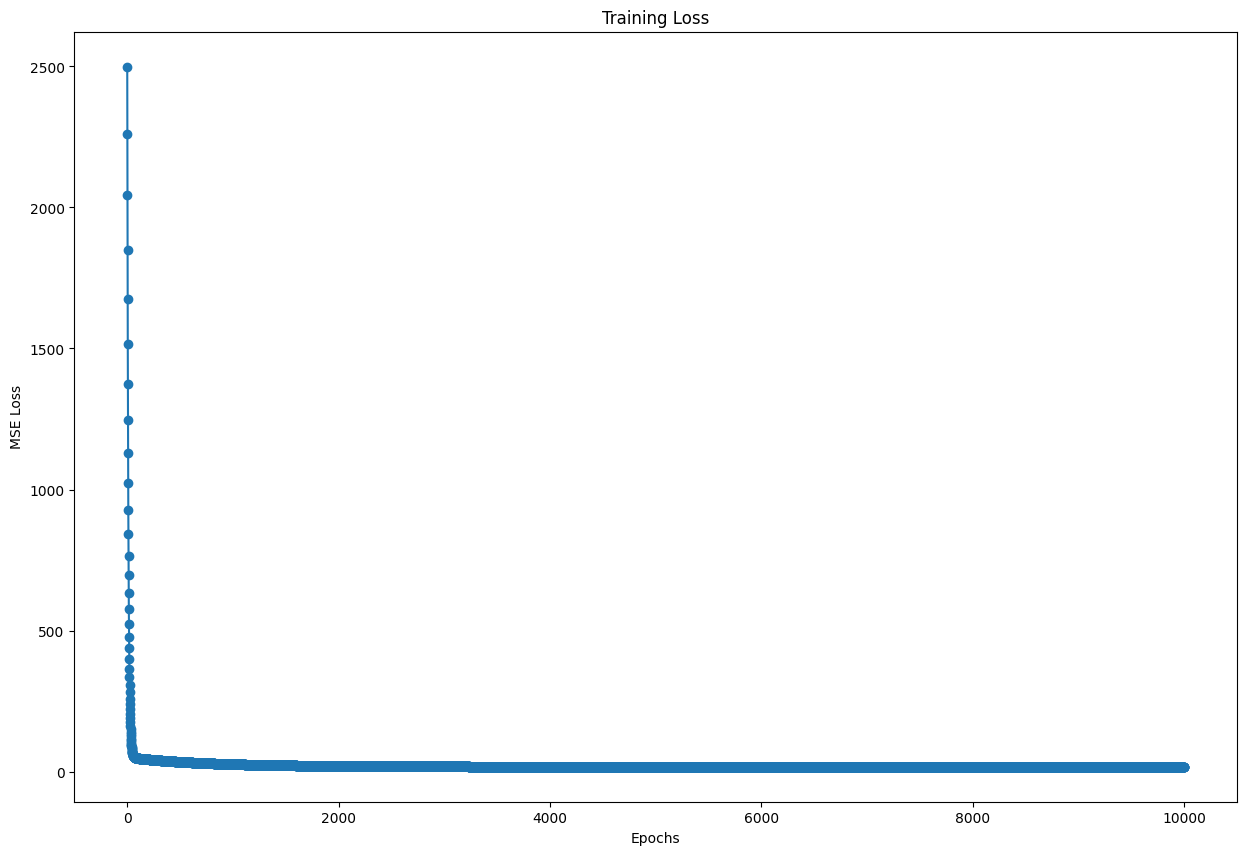

[ 0.49317201  0.28966578  0.92064715  0.13359959 -0.12580718  0.62110946
  0.22864836  0.87119538] 0.28696298989141106
3.985839231687971


In [42]:
LRGD = LinearRegression()
LRGD.gradient_descent_fit(X_train, y_train, lr=1e-5, epochs=10000)
LRGD.plot_learning_curve()
print(LRGD.gradient_descent_weights, LRGD.gradient_descent_intercept)
print(LRGD.gradient_descent_evaluate(X_val, y_val))

In [43]:
X_test = feature_extract(test_data, False)
X_test.shape
for x in X_test:
    if '*' in x or None in x:
        print(x)

In [47]:
prediction = LR.closed_form_predict(X_test)
prediction = [[f'index_{i}', prediction[i]] for i in range(len(prediction))]
prediction = pd.DataFrame(prediction, columns=['Index', 'answer'])
prediction.to_csv('./prediction.csv', index=False)

In [32]:
prediction = LRGD.closed_form_predict(X_test)
prediction = [[f'index_{i}', prediction[i]] for i in range(len(prediction))]
prediction = pd.DataFrame(prediction, columns=['Index', 'answer'])
prediction.to_csv('./prediction_gd.csv', index=False)

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'